In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-labels-idx1-ubyte


# How AutoEncoders Work - korean ver. -study ver.

https://www.kaggle.com/subinium/how-autoencoders-work-korean-ver

## 1. Image Reconstruction

## Load Libraries and Data set.

필요한 라이브러리들을 불러옵니다.

In [2]:
## LOAD LIBRARIES
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

Using TensorFlow backend.


데이터셋을 불러오고, 예측값과 타겟을 분리하며 입력 데이터를 정규화합니다.

In [3]:
## READ DATASET
train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## NORMALIZE AND RESHAPE THE PREDICTORS
train_x = train_x / 255

## CREAE TRAIN AND VALIDATION DATASETS
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## RESHAPE THE INPUTS
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

## Create Auto-encoder architecture

이제 오토인코더 구조를 만들어봅시다. 인코딩 부분은 3개의 레이어로 구성됩니다. <br>
(2000, 1200, 500 노드로 구성된) 인코딩 구조는 잠재 공간에 10개의 노드로 연결되고, 이 10개는 다시 각각 500, 1200, 2000개의 노드로 구성된 3개의 디코딩 구조로 연결됩니다. 그리고 마지막에 처음 인풋과 같은 노드의 수로 맞춰줍니다.

In [4]:
## INPUT LAYER
input_layer = Input(shape=(784, ))

# ENCODING ARCHITECTURE
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## LATENT VIEW
latent_view = Dense(10, activation='sigmoid')(encode_layer3)

## DECODING ARCHITECTURE
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## OUTPUT LAYER
output_layer = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

이제 모델을 확인해보자.

In [5]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              5010

조기 학습 종료를 이용하여 훈련을 해보자. (early stopping callback)

In [6]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 17s 351us/step - loss: 0.0970 - val_loss: 0.0705
Epoch 2/20
48000/48000 [==============================] - 16s 342us/step - loss: 0.0642 - val_loss: 0.0538
Epoch 3/20
48000/48000 [==============================] - 17s 345us/step - loss: 0.0502 - val_loss: 0.0442
Epoch 4/20
48000/48000 [==============================] - 17s 359us/step - loss: 0.0411 - val_loss: 0.0385
Epoch 5/20
48000/48000 [==============================] - 18s 380us/step - loss: 0.0372 - val_loss: 0.0356
Epoch 6/20
48000/48000 [==============================] - 17s 344us/step - loss: 0.0344 - val_loss: 0.0319
Epoch 7/20
48000/48000 [==============================] - 17s 348us/step - loss: 0.0313 - val_loss: 0.0299
Epoch 8/20
48000/48000 [==============================] - 17s 346us/step - loss: 0.0295 - val_loss: 0.0283
Epoch 9/20
48000/48000 [==============================] - 17s 347us/step - loss: 0.0273 - val_

검증 데이터에 예측을 생성합니다.

In [7]:
preds = model.predict(val_x)

원본 이미지와 예측 이미지를 그려봅시다.

**Inputs : Actual Images**

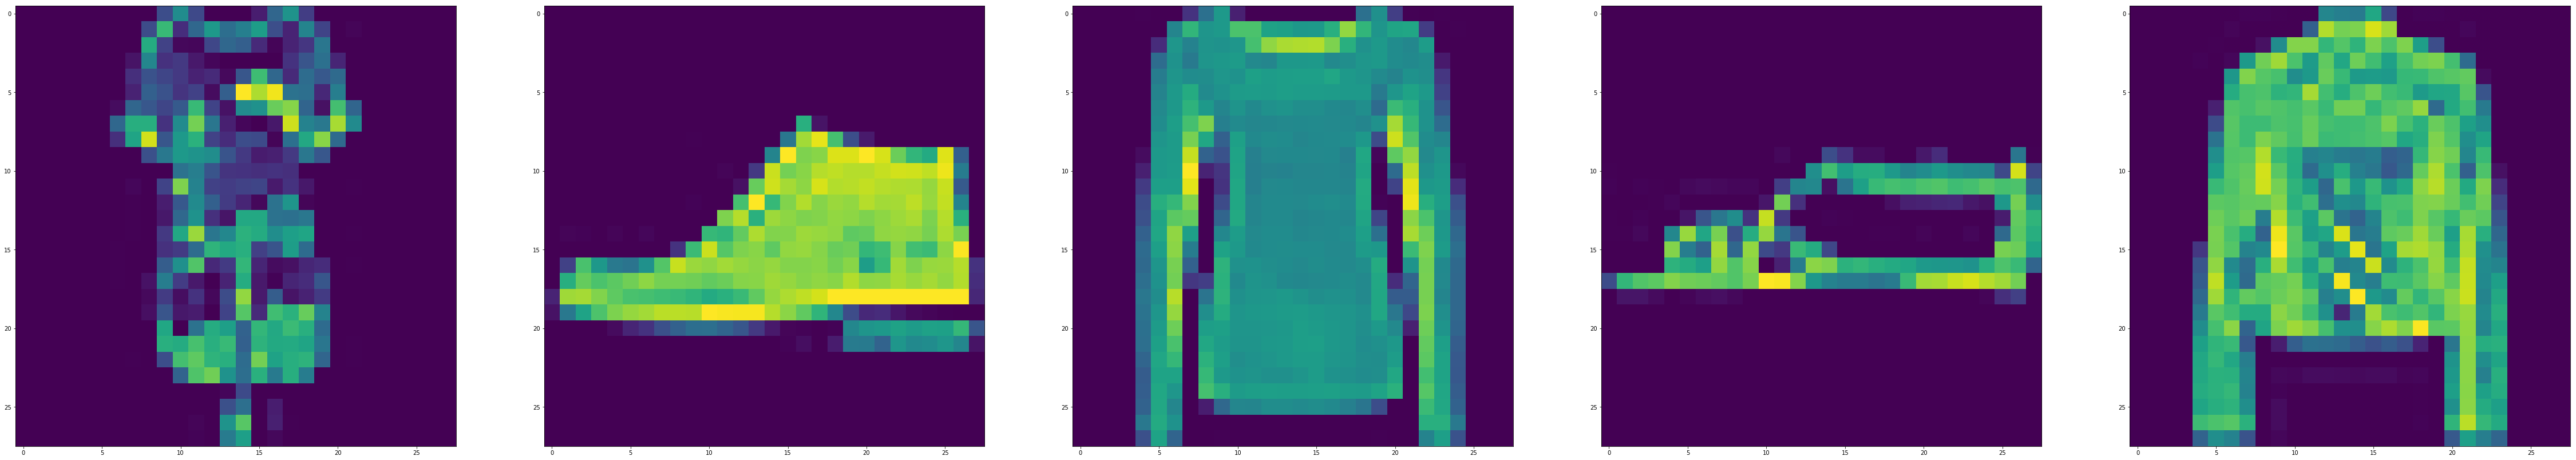

In [8]:
from PIL import Image
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)

for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
    
plt.show()

**Predicted : Auto-encoder Output**

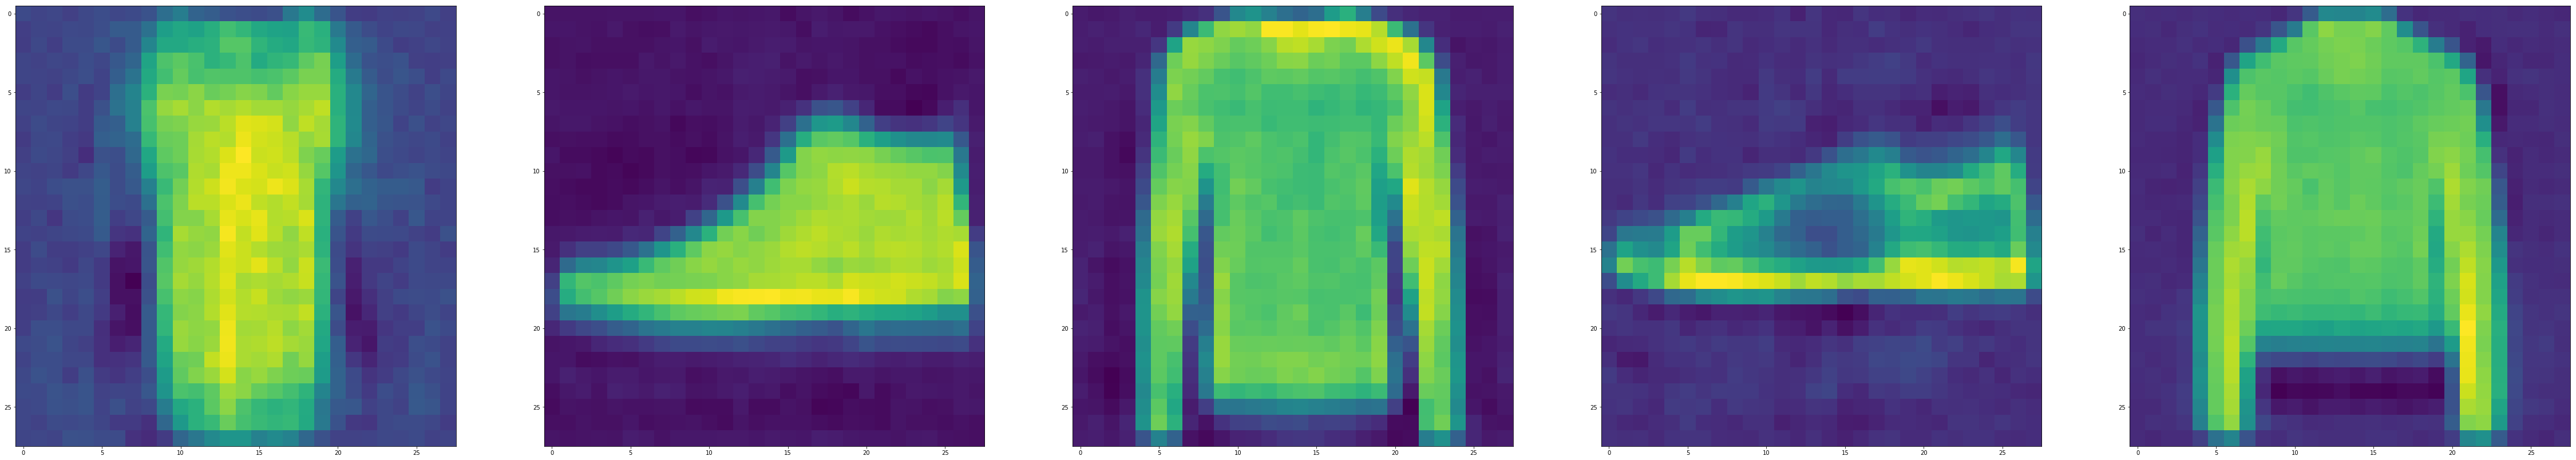

In [9]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))

plt.show()

20 epochs 만으로 입력 이미지를 다시 잘 구성하는 것을 확인할 수 있었습니다. <br>
이제 오토인코더로 노이즈를 없애는 예시를 살펴봅시다.

## 2. Image Denoising

오토인코딩은 매우 유용합니다. 다른 예시를 살펴봅시다.

많은 경우에 입력 이미지는 노이즈를 가지고 있는데 오토인코더는 이를 제거할 수 있습니다. <br>
우선 train_x와 val_x 데이터를 이미지 픽셀과 함께 준비해봅시다.

In [10]:
## RECREATE THE TRAIN_X ARRAY AND VAL_X ARRAY
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## NORMALIZE AND RESHAPE
train_x = train_x / 255.
val_x = val_x / 255.

이번 오토인코더 네트워크에는 convolutional layer을 추가합니다. 왜냐하면 Convolutional Networks는 이미지 입력에 대해 매우 잘 작동하기 때문입니다. 입력 데이터를 Convolutional Networks에 넣기 위해서는 28 * 28 matrix로 reshape해야합니다.

In [11]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

**Nosiy Images**

우리는 의도적으로 이미지에 노이즈를 추가할 수 있습니다. 이미지를 보완하는 imaug 패키지를 이용하여, 반대로 이미지에 노이즈를 만들 수 있습니다. 노이즈에는 다음과 같은 것들이 있습니다.

- Salt and Pepper Noise
- Gaussian Noise
- Periodic  Noise
- Speckle Noise

여기서는 impulse noise라고 불리는 Salt and Pepper Noise를 사용했습니다. <br>
이 노이즈는 선명하고 갑작스러운 노이즈를 만들고 희소하게 검정/흰 픽셀을 만듭니다.

In [12]:
# LETS ADD SAMPLE NOISE - SALT AND PEPPER
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

#### Before adding noise

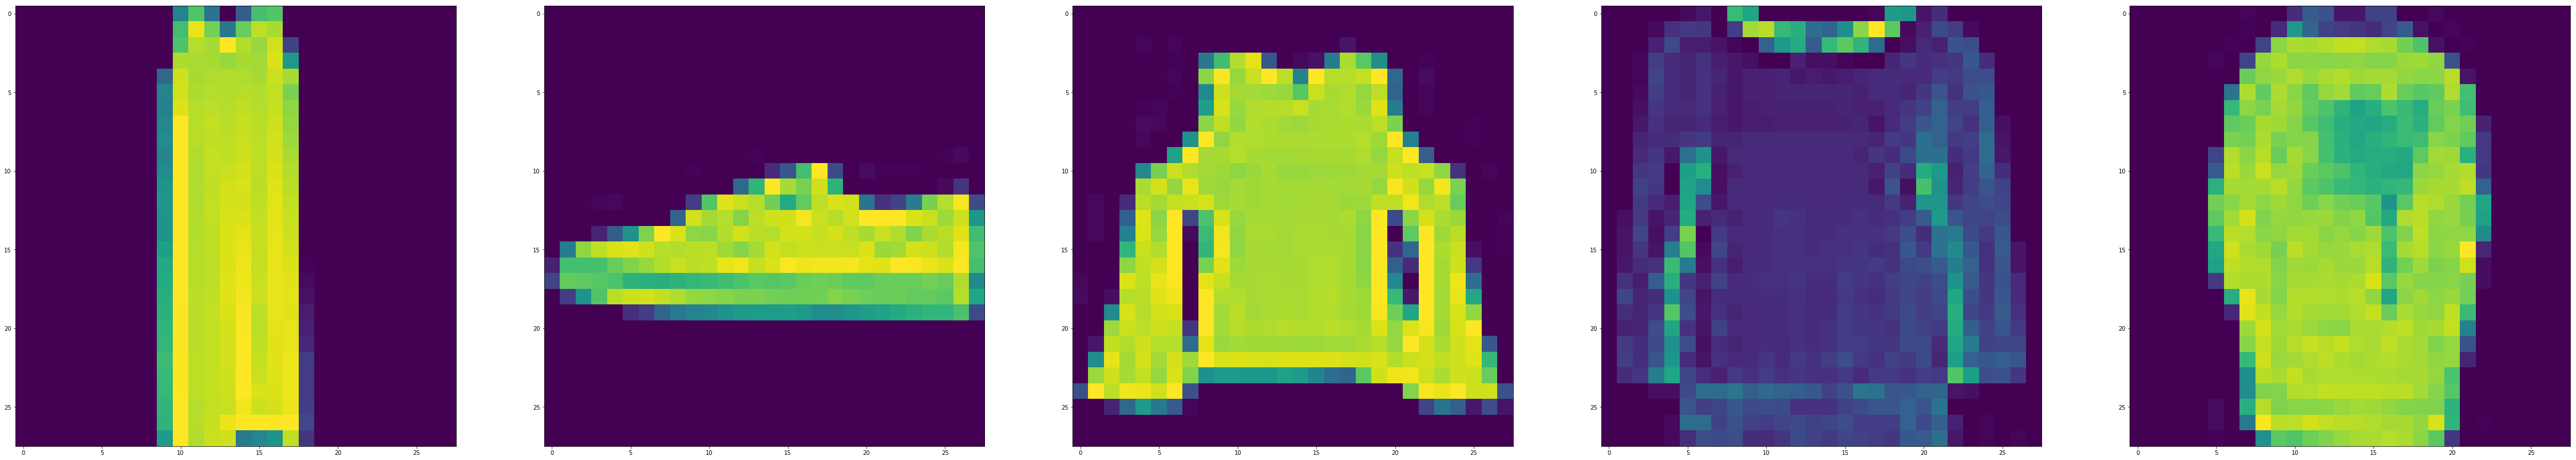

In [13]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5, 10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
    
plt.show()

#### After adding noise

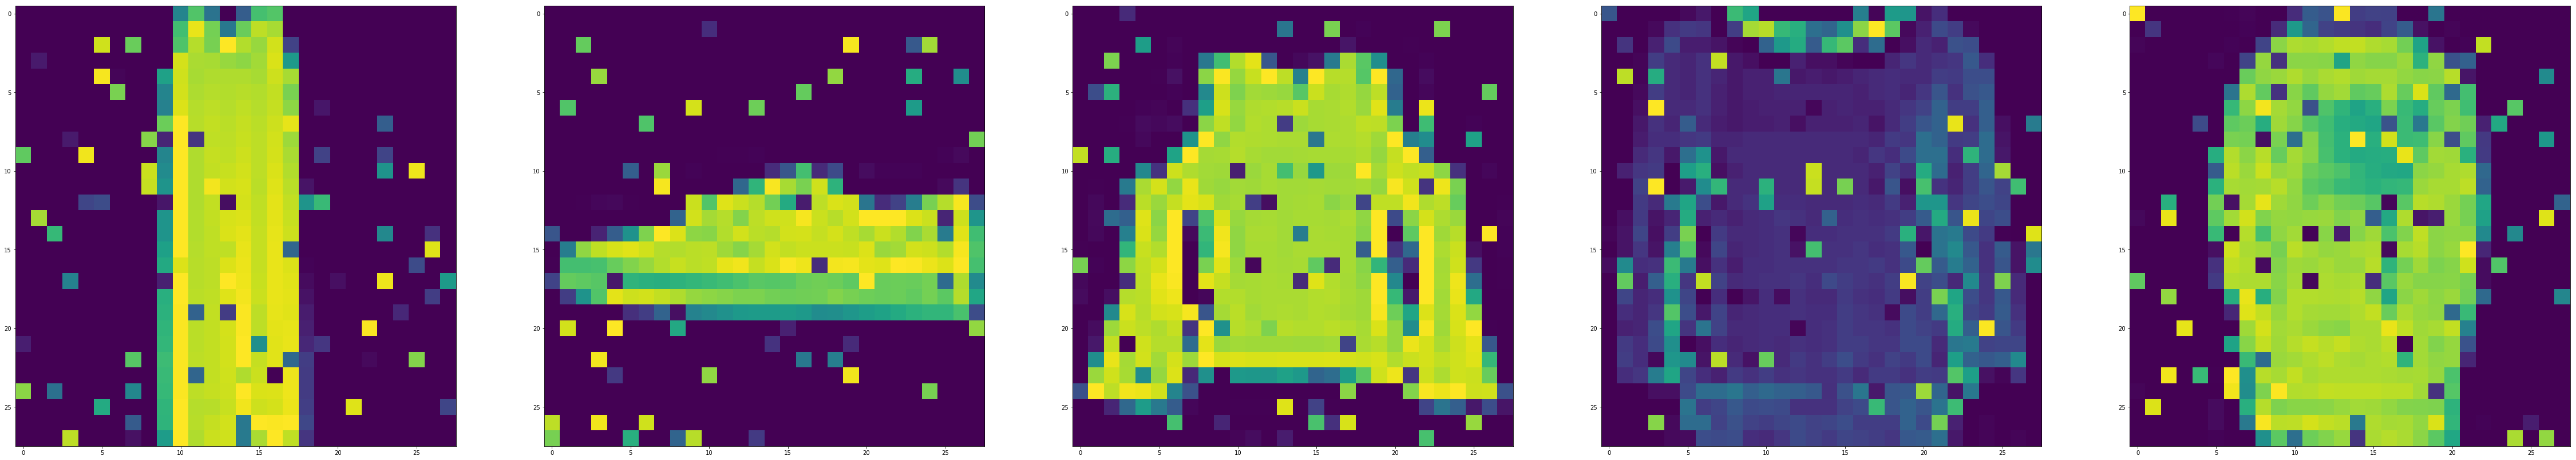

In [14]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5, 10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
    
plt.show()

오토인코더를 위한 모델을 만들어보기 전에 어떤 종류의 네트워크가 필요한지 알아봅시다.

#### Encoding Architecture

인코딩 구조는 3개의 Convolutional Layer과 3개의 Max Pooling 레이어를 하나하나 쌓아 구성됩니다. Relu를 활성화함수로 사용하고, same 매개변수로 이미지 크기를 패딩을 통해 유지합니다.

Max pooling layer의 역할은 이미지 차원을 다운샘플링하기 위해 사용됩니다. 이 레이어는 초기 표현의 겹치지 않는 부분 영역에 최대 필터를 적용합니다.

#### Decoding Architecture

디코딩 구조에서도 거의 유사하게 3개의 Convolutional Layer를 사용합니다. 하지만 Max Pooling layer 3개 대신에 Upsampling layer 3개를 사용합니다. 활성화함수와 패딩은 인코딩과 동일합니다.

Upsampling layer의 역할은 입력 벡터를 더 높은 차원으로 업샘플링하기 위해 사용합니다. Max pooling 연산은 비가역이지만, 각 풀링 영역 내에 최대 값의 위치를 기록함으로써 근사 역을 구할 수 있습니다. Upsampling 레이어는 이 속성을 사용하여 낮은 차원의 특징 공간에서 재구성합니다.

In [15]:
# INPUT LAYER
input_layer = Input(shape=(28, 28, 1))

# ENCODING ARCHITECTURE
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view = MaxPool2D((2, 2), padding='same')(encoded_layer3)

# DECODING ARCHITECTURE
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# COMPILE THE MODEL
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

모델 정보는 다음과 같습니다.

In [16]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0   

이번에도 조기 학습 종료로 학습시켜봅시다.

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=30, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 143s 3ms/step - loss: 0.1061 - val_loss: 0.0591
Epoch 2/30
48000/48000 [==============================] - 140s 3ms/step - loss: 0.0460 - val_loss: 0.0380
Epoch 3/30
48000/48000 [==============================] - 139s 3ms/step - loss: 0.0349 - val_loss: 0.0323
Epoch 4/30
48000/48000 [==============================] - 140s 3ms/step - loss: 0.0301 - val_loss: 0.0281
Epoch 5/30
48000/48000 [==============================] - 143s 3ms/step - loss: 0.0266 - val_loss: 0.0254
Epoch 6/30
48000/48000 [==============================] - 139s 3ms/step - loss: 0.0245 - val_loss: 0.0237
Epoch 7/30
48000/48000 [==============================] - 138s 3ms/step - loss: 0.0231 - val_loss: 0.0225
Epoch 8/30
48000/48000 [==============================] - 139s 3ms/step - loss: 0.0220 - val_loss: 0.0218
Epoch 9/30
48000/48000 [==============================] - 139s 3ms/step - loss: 0.0212 - val_loss: 0.0

모델의 예측 결과를 검증 데이터에서 살펴봅시다.

- 노이즈 적용된 검증 데이터

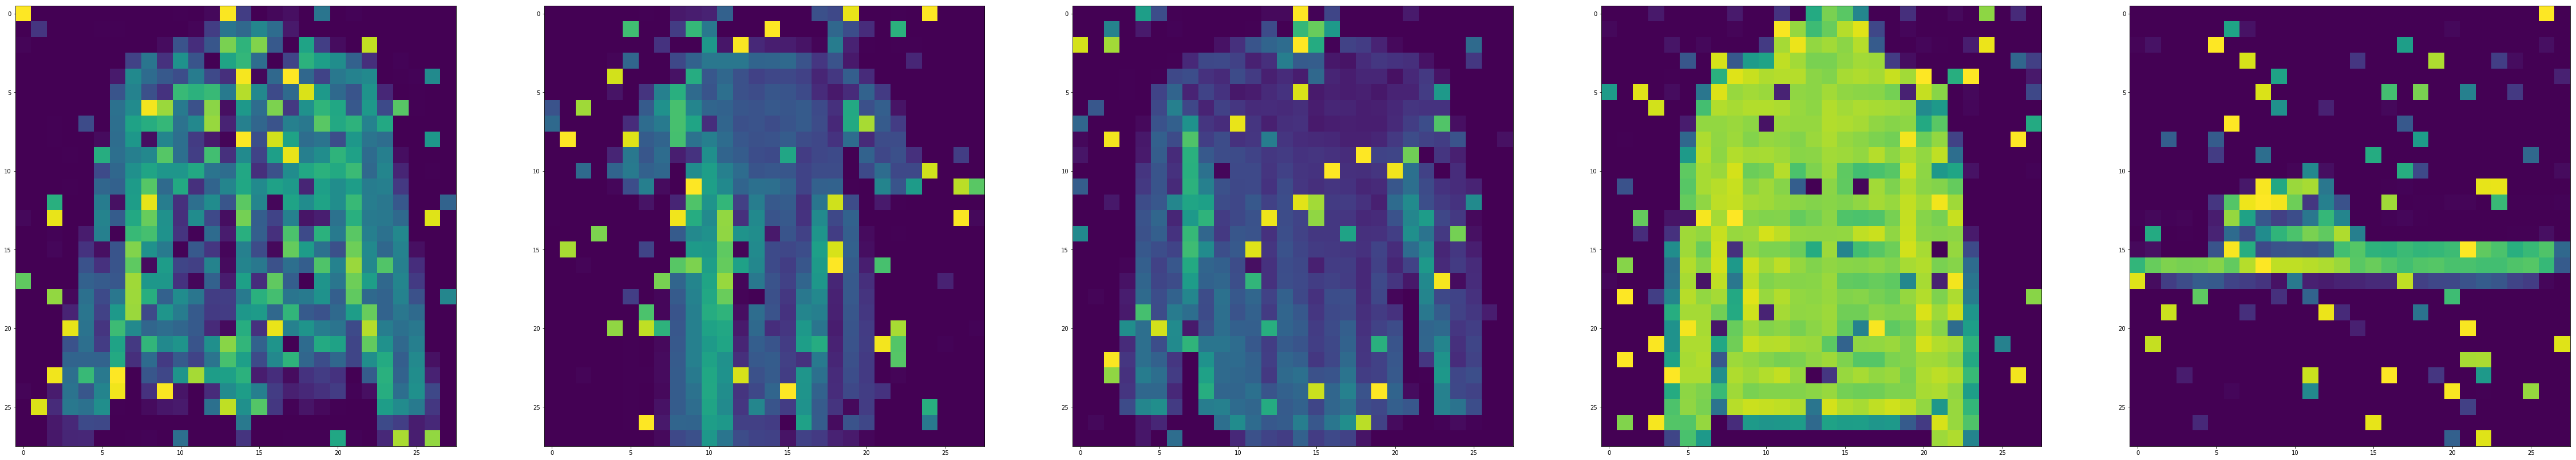

In [18]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5, 10):
    ax[i-5].imshow(val_x_n[i].reshape(28, 28))

plt.show()

- 노이즈를 없앤 오토인코딩 후 검증 데이터

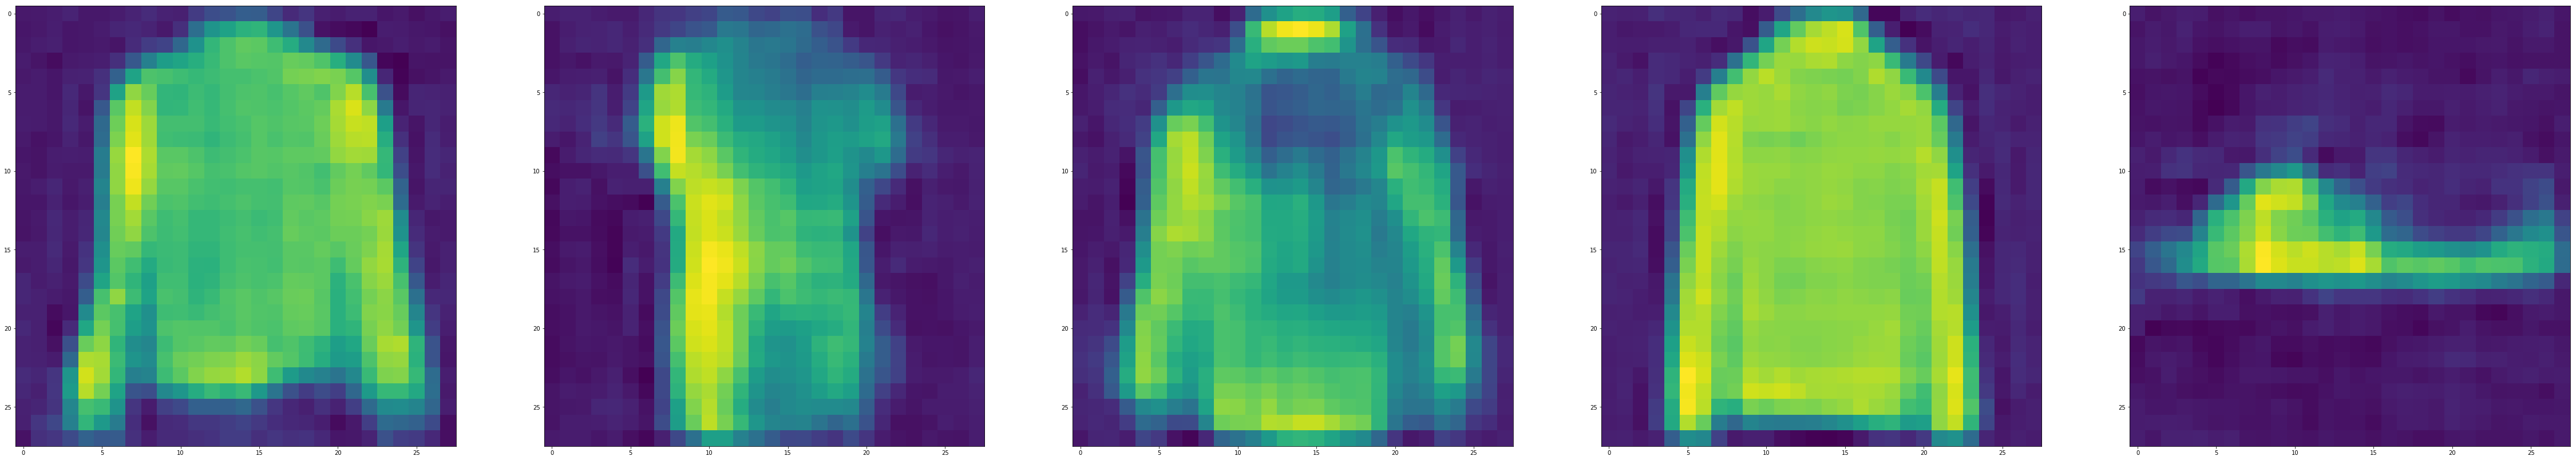

In [19]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1, 5)
f.set_size_inches(80, 40)
for i in range(5, 10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
    
plt.show()

## 3. Sequence to Sequence Prediction using AutoEncoder

앞의 예시에서는 기본적으로 2차원 데이터였고, 이번 sequence 데이터는 1차원 데이터입니다.

이런 시퀀스 데이터의 예시에는 시계열 데이터와 문자열 데이터가 있습니다. 이 예시에서는 기계 번역 등에 적용할 수 있습니다. 이미지에 CNN을 사용했다면, 이 케이스에서는 LSTM을 사용합니다.

**Autoencoder Architecture**

우선 LSTM이 이 구조에서 어떤 방식으로 작동하는지 알아봅시다.

- Long Short-Term Memory, LSTM은 내부 루프로 구성된 반복적 신경망입니다. (RNN)
- 다른 RNN과 다르게 backpropagation throught time, BPTT를 활용하여 효과적으로 훈려나고, 사라지는 그래디언트 문제를 방지합니다.
- LSTM layer에서 메모리 유닛을 정의할 수 있고 layer에 속하지 않은 각 유닛은 셀의 상태를 나타내는 c와 숨겨진 상태이자 출력인 h 등이 있습니다.
- Keras를 사용하면, LSTM 레이어의 출력 상태와 LSTM 레이어의 현재 상태에 모두 접근할 수 있습니다.

이제 학습과 생성을 하는 오토인코더 구조를 만들어봅시다. 2가지의 요소로 이루어집니다.

- 시퀀스를 입력으로 받아들이고 LSTM의 현재 상태를 출력으로 반환하는 인코더 아키텍처
- 시퀀스 및 인코더 LSTM 상태를 입력으로 받아 디코딩 된 출력 시퀀스를 반환하는 디코더 아키텍처
- LSTM의 숨겨진 상태와 메모리 상태를 저장하고 (숨겨진 그리고 상태들을) 접근하므로, 보이지 않는 데이터에 대한 예측을 생성하는 동안 LSTM을 사용할 수 있습니다.

우선, 고정 길이의 무작위 시퀀스를 포함하는 시쿼스 데이터 세트를 생성합니다. 우리는 무작위 순서를 생성하는 함수를 생성할 것 입니다.

- X1은 난수를 포함하는 입력 시퀀스를 의미합니다.
- X2는 시퀀스의 다른 요소를 재생산하기 위해 시드로 사용되는 패딩 된 시퀀스를 의미합니다.
- y는 대상 시퀀스 또는 실제 시퀀스를 나타냅니다.

In [20]:
def dataset_preparation(n_in, n_out, n_unique, n_samples):
    X1, X2, y = [], [], []
    for _ in range(n_samples):
        ## create random numbers sequence - input
        inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]
        
        ## create target sequence
        target = inp_seq[:n_out]
        
        ## create padded sequence / seed sequence
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]
        
        # convert the elements to categorical using keras api
        X1.append(to_categorical([inp_seq], num_classes=n_unique))
        X2.append(to_categorical([seed_seq], num_classes=n_unique))
        y.append(to_categorical([target_seq], num_classes=n_unique))
        
    # remove unnecessary dimention
    # expand_dims()는 차원을 늘리는 함수, squeeze()는 차원을 줄이는 함수.
    # https://nabzacko.tistory.com/3
    X1 = np.squeeze(np.array(X1), axis=1)
    X2 = np.squeeze(np.array(X2), axis=1)
    y  = np.squeeze(np.array(y), axis=1)
    
    return X1, X2, y

samples = 100000
features = 51
inp_size = 6
out_size = 3

inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)

print("Shapes: ", inputs.shape, seeds.shape, outputs.shape)
print ("Here is first categorically encoded input sequence looks like: ", )
inputs[0][0]

Shapes:  (100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
Here is first categorically encoded input sequence looks like: 


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

이제 케라스에서 모델을 만들어봅시다.

In [21]:
def define_models(n_input, n_output):
    ## define the encoder architecture
    ## input : sequence
    ## output : encoder states
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    ## define the encoder-decoder architecture
    ## input : a seed sequence
    ## output : decoder states, decoded output
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    ## define the decoder model
    ## input : current states + encoded sequence
    ## output : decoded sequence
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = define_models(features, features)

In [22]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 51)          0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 128), (None, 128) 92160     
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


In [23]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 input_5[0][0]              

In [24]:
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 92160       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 lstm_1[0][1]               

이제 오토인코더 모델을 아담옵티마이저와 Categorical Cross Entropy를 손실함수로 사용하여 훈련해봅시다.

In [25]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
autoencoder.fit([inputs, seeds], outputs, epochs=1)

Epoch 1/1
100000/100000 [==============================] - 36s 360us/step - loss: 0.6562 - acc: 0.7925


이제 입력 시퀀스를 이용해 시퀀스를 예측하는 함수를 만들어봅시다.

In [27]:
def reverse_onehot(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

def predict_sequence(encoder, decoder, sequence):
    output = []
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1, 1, features)
    
    current_state = encoder.predict(sequence)
    for t in range(out_size):
        pred, h, c = decoder.predict([target_seq] + current_state)
        output.append(pred[0, 0, :])
        current_state = [h, c]
        target_seq = pred
    
    return np.array(output)

이제 예측을 만들어 봅시다.

In [28]:
for k in range(5):
    X1, X2, y = dataset_preparation(inp_size, out_size, features, 1)
    target = predict_sequence(encoder_model, decoder_model, X1)
    print('\n Input Sequence=%s SeedSequence=%s, PredictedSequence=%s' % (reverse_onehot(X1[0]), reverse_onehot(y[0]), reverse_onehot(target)))


 Input Sequence=[30, 7, 35, 6, 37, 14] SeedSequence=[35, 7, 30], PredictedSequence=[35, 7, 30]

 Input Sequence=[17, 35, 5, 2, 39, 48] SeedSequence=[5, 35, 17], PredictedSequence=[5, 35, 17]

 Input Sequence=[43, 49, 5, 34, 15, 50] SeedSequence=[5, 49, 43], PredictedSequence=[5, 49, 43]

 Input Sequence=[48, 11, 43, 21, 44, 4] SeedSequence=[43, 11, 48], PredictedSequence=[43, 11, 48]

 Input Sequence=[25, 5, 19, 11, 46, 37] SeedSequence=[19, 5, 25], PredictedSequence=[19, 5, 25]
